In [1]:
# import required libarries 
import pandas as pd
import numpy as np
import yfinance as yf 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
"""Data Collection"""
# one day - 1 min interval
gold_one_day = yf.download('GC=F', interval="1m")
# one month - 5 min interval
gold_one_month = yf.download('GC=F', interval="5m", period="1mo")
# one year - 1 day interval
gold_one_year = yf.download('GC=F', period="1y")
# ten years - 1 day interval 
gold_ten_year = yf.download('GC=F', period="10y")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data Wrangling

In [3]:
def data_wrangle(path, droped_columns):
    """ A method that will clean the original dataset, 
        restructure the dataset and fill the missing values.
        
        input
        -----
        path: data path 
        dropped_columns: columns to be dropped"""
    
    # read the dataset through the path
    df=pd.read_csv(path)
    # change the "Date" column to datetime data type
    df['Date']=pd.to_datetime(df['Date'])
    # set the "Date" column to index
    df=df.set_index('Date')
    # assigned the desired frequecy to set up
    # 'D' stands for day
    desired_frequency = 'D'
    # set the frequency 
    df = df.asfreq(desired_frequency)
    # drop the unnecessary columns that are already specified 
    df = df.drop(columns=droped_columns)
    # fill the missing values 
    df=df.fillna(method='ffill')
    return df

In [4]:
# dataframe 
df_one_year = data_wrangle('data/gold_one_year.csv', ['Adj Close', 'Volume'])

C:\Users\user\AppData\Local\Temp\ipykernel_8804\493660491.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df=df.fillna(method='ffill')


In [5]:
print("Dataframe's shape", df_one_year.shape)

Dataframe's shape (367, 4)


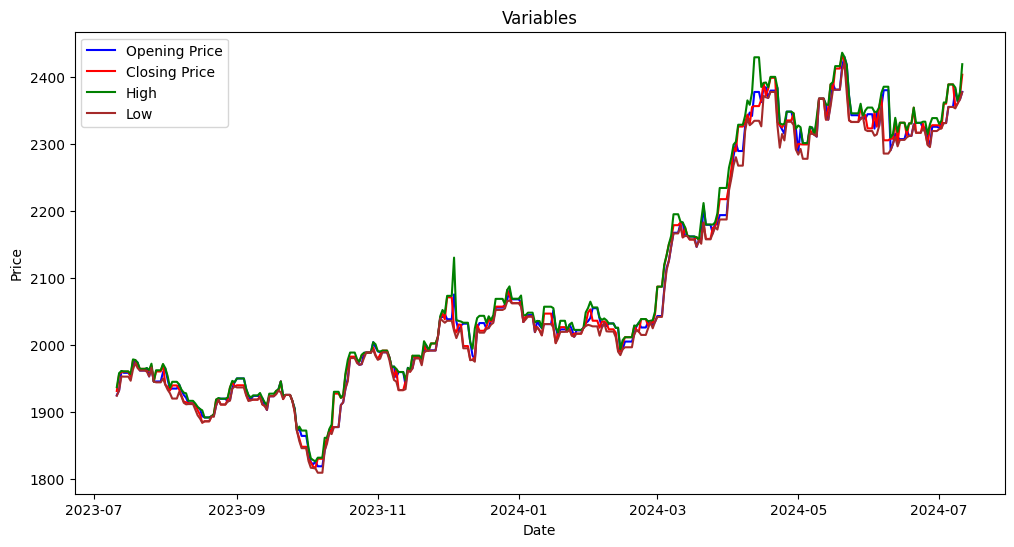

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df_one_year['Open'], label='Opening Price', color='blue')
plt.plot(df_one_year['Close'], label='Closing Price', color='red')
plt.plot(df_one_year['High'], label='High', color='green')
plt.plot(df_one_year['Low'], label='Low', color='brown')
plt.title('Variables')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

There is a common pattern between these different variables. We can run the Johansen's test.

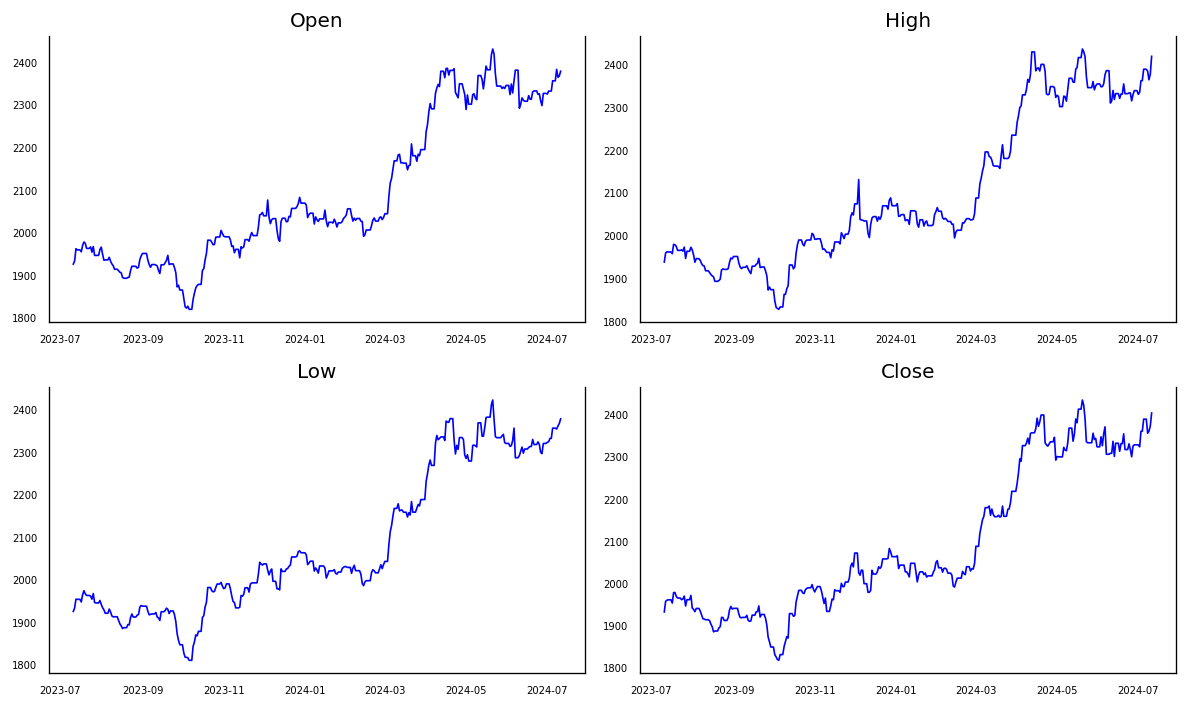

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_one_year[df_one_year.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_one_year.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();